# CEE 598: Uncertainty Quantification
## Assignment Three
### Noah Garfinkle (garfink2@illinois edu)
### 03 March 2020

## Imports and Setup

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd

## Problem One

Similar to importance sampling example in lecture notes, we would lke now to calculate $\theta = P(X>2)$ where $X$ is distributed according to the standard Cauchy PDF, given by

$$
f_X(x) = \frac{1}{\pi(1+x^2)}
$$

Consider the proposal to be $q_x(x) = \frac{2}{x^2}$ defined over the domain of interest.  Write a Monte Carlo (MC) integration code, as well as importance sampling code for the estimation of $\theta$.  The input to these codes should be the size of the sample set $n$.  Let $\hat{\theta_f}$ be the result obtained from standard MC method and $\hat{\theta_g}$ be that from importance sampling.

### (a) Compare the convergence behaviors for $\hat{\theta_f}$ and $\hat{\theta_g}$.

In [121]:
def f(x):
    fx = 1 / (np.pi*(1+np.power(x,2)))
    return fx

In [122]:
def q(x):
    qx = 2 / np.power(x,2)
    return qx

Plot to compare the distributions

In [123]:
xs = np.linspace(1.9,10,200)
fs = [f(x) for x in xs]
qs = [q(x) for x in xs]

Text(0, 0.5, '$P(X==x)$')

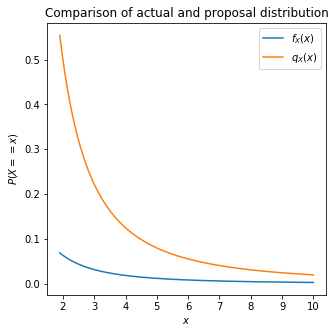

In [124]:
fig,ax = plt.subplots(figsize=(5,5))
sns.lineplot(xs,fs,label="$f_X(x)$",ax=ax)
sns.lineplot(xs,qs,label="$q_X(x)$",ax=ax)
ax.set_title("Comparison of actual and proposal distribution")
ax.set_xlabel("$x$")
ax.set_ylabel("$P(X==x)$")

In [315]:
stats.cauchy.cdf(100000)-stats.cauchy.cdf(2)

0.14758043455157155

#### Monte Carlo Integration

Approach:

Let us assume that the maximum value of the distirbution, per the figure above, is 0.1.  Therefore, we will randomly select values on the x axis between 2 and a very large number (or a number with a very small probability along the tail, perhaps even as low as 10), and between 0 and 0.1.  We will check whether they fall under the curve.

In [445]:
n = 10000
min_x = 2.0
max_x = 100
min_y = 0.0
max_y = 0.1
sample_xs = []
sample_ys = []
p_xs = []
sample_hits = []
for i in range(0,n):
    sample_x = np.random.random() * max_x
    sample_y = np.random.random() * max_y
    p_x = f(sample_x)
    if sample_y < p_x:
        sample_hits.append(True)
    else:
        sample_hits.append(False)
    sample_xs.append(sample_x)
    sample_ys.append(sample_y)
    p_xs.append(p_x)
df = pd.DataFrame({"x":sample_xs,"y":sample_ys,"f(x)":p_xs,"hit":sample_hits})

In [446]:
df.head()

,x,y,f(x),hit
0,85.058751,0.055027,0.000044,False
1,62.967165,0.003045,0.000080,False
2,20.134865,0.059543,0.000783,False
3,22.629135,0.018041,0.000620,False
4,22.062573,0.097755,0.000653,False


In [447]:
area_rectangle = (max_x-min_x) * (max_y-min_y)
nHits = len(df[(df["hit"]==True) & (df["x"]>min_x)])
fractionHits = nHits / n
fractionArea = fractionHits * area_rectangle

In [448]:
fractionArea

0.14014000000000001

Text(0.5, 1.0, 'Monte Carlo approach to area estimation with 10000 samples\n$P(x>2)=0.14$')

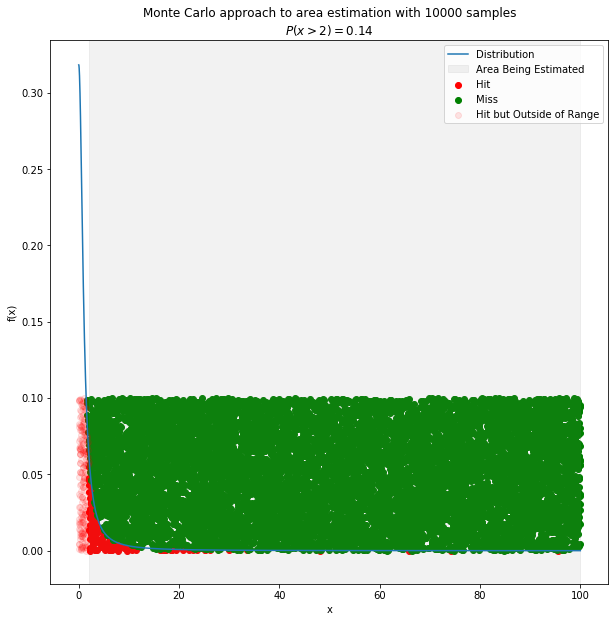

In [449]:
fig,ax = plt.subplots(figsize=(10,10))
df_Miss = df[df["hit"]==False]
df_hitAbove2 = df[(df["hit"]==True) & (df["x"]>min_x)]
df_hitBelow2 = df[(df["hit"]==True) & (df["x"]<=min_x)]
ax.scatter(x=df_hitAbove2["x"],y=df_hitAbove2["y"],color="red",label="Hit")
ax.scatter(x=df_Miss["x"],y=df_Miss["y"],color="green",label="Miss")
ax.scatter(x=df_hitBelow2["x"],y=df_hitBelow2["y"],color="red",label="Hit but Outside of Range",alpha=0.1)
ax.axvspan(min_x,max_x,alpha=0.1,color="grey",label="Area Being Estimated")
sns.lineplot(x="x",y="f(x)",data=df,ax=ax,label="Distribution")
ax.set_title(f"Monte Carlo approach to area estimation with {n} samples\n$P(x>2)={fractionArea:,.2f}$")

#### Importance Sampling

References

- https://astrostatistics.psu.edu/su14/lectures/cisewski_is.pdf

In [450]:
sample_xs = []
sample_ys = []
p_xs = []
sample_hits = []

n = 100000
Pz = 0.0
for i in range(0,n):
    # pick a random x
    x = np.random.random()*max_x
    sample_xs.append(x)
    if x > min_x:
        Pz += f(x) / q(x)
Pz /= n

In [451]:
Pz

0.15509608078881187

#### Discussion

### (b) At each sample number, use the previous samples to calculate the sample variance for the $\theta$ estimates, i.e. $Var(\hat{\theta_f})$ and $Var(\hat{\theta_g})$.  Compare these two measures and their convergences.

References

- https://people.duke.edu/~ccc14/sta-663/MonteCarlo.html

### (c) Discuss your observations

## Problem Two

Write a Metropolis-Hastings code that can be used to draw samples from the Rayleigh PDF given by

$$
f(x;\sigma)=\frac{x}{\sigma^2}e^{\frac{-x^2}{2\sigma^2}}, x\geq0
$$

Choose the proposal to be $q(y|x)=N(x,\sigma_q^2)$

In [317]:
def f_rayleigh(x,σ):
    p = x / np.power(σ,2)*np.exp(-np.power(x,2)/(2*np.power(σ,2)))
    return p

In [326]:
def q_proposal(σ):
    q = stats.norm.rvs(scale=σ)
    return q

In [331]:
def pdf_q_proposal(x,σ):
    p = stats.norm.pdf(x,scale=σ)
    return p

In [333]:
# I think what actually needs to happen here is my proposal is a normal distribution centered on x and with σ
def q_x(x,σ):
    normalDist = stats.norm(loc=x,scale=σ)
    proposedValue = normalDist.rvs()
    return proposedValue

In [343]:
q_x(1,1)

1.33835189031401

First, we begin by ensuring that our impelmented distribution matches an accepted distribution.

In [327]:
xs = np.linspace(0,10,100)
fs_rayleigh = [f_rayleigh(x,1) for x in xs]
pdf_rayleigh = [stats.rayleigh.pdf(x,scale=1) for x in xs]

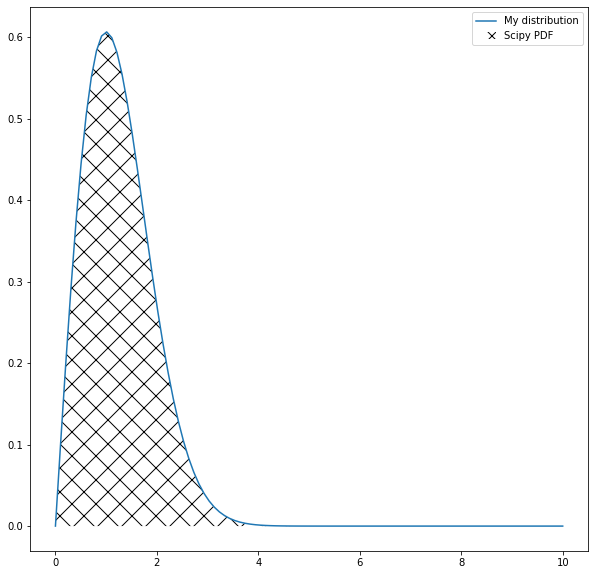

In [328]:
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(xs,fs_rayleigh,label="My distribution",ax=ax)
# sns.lineplot(xs,pdf_rayleigh,label="Scipy",ax=ax)
ax.fill_between(xs,pdf_rayleigh,hatch='x',facecolor="white",label="Scipy PDF")
ax.legend()

### (a) Assume $\sigma = \sigma_q = 1$.  We have two ways to implement the algorithm now that the supports of $f$ and $q$ are different:

_Option a.1_: We draw samples from the proposal distribution, and only if they fall inside the domain interest, we consider them a candidate, based on which we evaluate the rejection probability and move to the acceptance/rejection step.  That is, if they don't fall inside the support of $f$ we don't make a self-transition, and just free the step timer, until a proposal falls inside the support.

_Option a.2_: We draw samples from the proposal distribution, and no matter where they fall (inside or outside the domain of interest), we treat them as a candidate, based on which we evaluate the rejection probability and move to the acceptance/rejection step.  That is, no matter where the proposal draw is, we will not freeze the time stepper.

Compare the two sample populations generated using these two codes with the target distribution and commennt on the options you would pick.

General Approach:

1. Set an initial value of x
2. For t = 1,2,...

    a. Obtain a proposed value from q
    
    b. Calculate the acceptance probability
    
    c. Based on the acceptance probability ,either set the next value as the proposed value or stay in place

References:
- https://stephens999.github.io/fiveMinuteStats/MH_intro.html
- https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

#### Option a.1

In [429]:
iterations = []
xs = []
proposedXs = []
arr_Accepted = []

x = 1.0
σ = 1
σ_q = 1
for t in range(0,100000):
    check = -1
    while check < 0:
        # obtain a proposed value from q
        proposedValue = q_x(x,σ_q)
        # calculate the acceptance probability
        acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
        check = f_rayleigh(proposedValue,σ)
        accepted = False
        # check if it falls within the support for fx (positive probability)
        if acceptanceRatio == 1: #accept
            x = proposedValue
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < acceptanceRatio:
                x = proposedValue
                accepted = True
            else:
                pass
    iterations.append(t)
    xs.append(x)
    proposedXs.append(proposedValue)
    arr_Accepted.append(accepted)
df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})

Text(0, 0.5, '$x$')

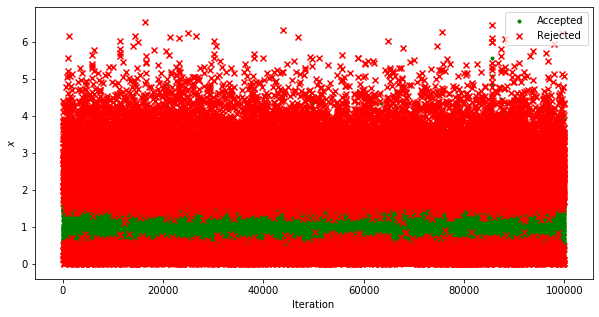

In [430]:
df_Accepted = df[df["accepted"]==True]
df_Rejected = df[df["accepted"]==False]

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("$x$")

In [431]:
df["x"].mean()

1.3379193291877378

In [432]:
σ*np.power(np.pi/2,.5) # the true expected value of a Rayleigh distribution per https://www.statisticshowto.datasciencecentral.com/rayleigh-distribution/

1.2533141373155001

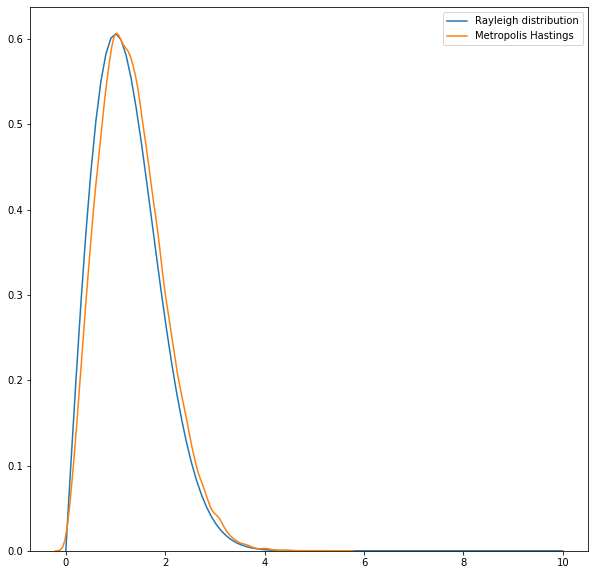

In [433]:
xs = np.linspace(0,10,100)
fs_rayleigh = [f_rayleigh(x,1) for x in xs]
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
ax.legend()

#### Option a.2

In [399]:
iterations = []
xs = []
proposedXs = []
arr_Accepted = []

x = 1.0
σ = 1
σ_q = 1
for t in range(0,100000):
    # obtain a proposed value from q
    proposedValue = q_x(x,σ_q)
    # calculate the acceptance probability
    acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
    accepted = False
    if acceptanceRatio == 1: #accept
        x = proposedValue
        accepted = True
    else: # draw a random number and take the probability from acceptanceRatio
        rand = np.random.random()
        if rand < acceptanceRatio:
            x = proposedValue
            accepted = True
        else:
            pass
    iterations.append(t)
    xs.append(x)
    proposedXs.append(proposedValue)
    arr_Accepted.append(accepted)
#     print(f"Step {t}, current value: {x}, proposed value: {proposedValue}, acceptance ratio: {acceptanceRatio}, accepted: {accepted}")
df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})

Text(0, 0.5, '$x$')

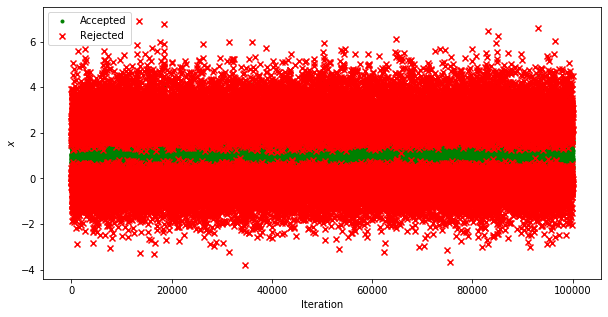

In [400]:
df_Accepted = df[df["accepted"]==True]
df_Rejected = df[df["accepted"]==False]

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("$x$")

In [401]:
df["x"].mean()

1.252149591318554

In [402]:
σ*np.power(np.pi/2,.5) # the true expected value of a Rayleigh distribution per https://www.statisticshowto.datasciencecentral.com/rayleigh-distribution/

1.2533141373155001

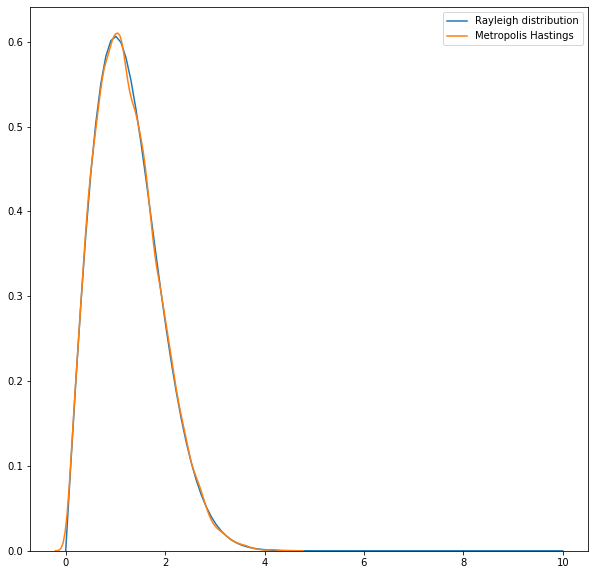

In [403]:
xs = np.linspace(0,10,100)
fs_rayleigh = [f_rayleigh(x,1) for x in xs]
fig,ax = plt.subplots(figsize=(10,10))
sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
ax.legend()

Text(0, 0.5, '$x$')

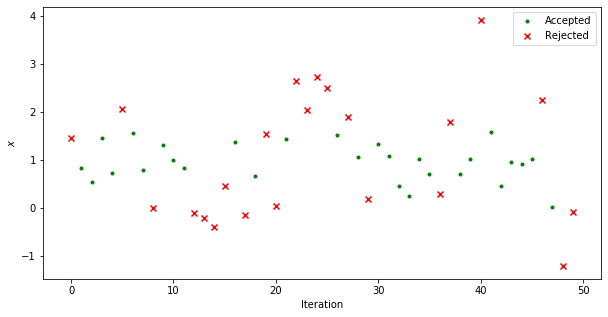

In [410]:
# Replicate the plot for the early iterations to show convergence behavior
df_Early = df[df["t"]<50]
df_Early_Accepted = df_Early[df_Early["accepted"]==True]
df_Early_Rejected = df_Early[df_Early["accepted"]==False]

fig,ax = plt.subplots(figsize=(10,5))
ax.scatter(df_Early_Accepted["t"],df_Early_Accepted["x"],label="Accepted",marker=".",color="green")
ax.scatter(df_Early_Rejected["t"],df_Early_Rejected["proposals"],label="Rejected",marker="x",color="red")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("$x$")

### (b) Assume $\sigma = 1$ in the target Rayleigh distribution.  Determine what choice of $\sigma_q$ will lead to a better sampling algorithm.  Include details about your thought process and numerical tests in reaching a good proposal.

In [413]:
def metropolisHastings(x=1.0,σ=1,σ_q=1,n=10000):
    iterations = []
    xs = []
    proposedXs = []
    arr_Accepted = []

    for t in range(0,n):
        # obtain a proposed value from q
        proposedValue = q_x(x,σ_q)
        # calculate the acceptance probability
        acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
        accepted = False
        if acceptanceRatio == 1: #accept
            x = proposedValue
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < acceptanceRatio:
                x = proposedValue
                accepted = True
            else:
                pass
        iterations.append(t)
        xs.append(x)
        proposedXs.append(proposedValue)
        arr_Accepted.append(accepted)
    df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})
    
    df_Accepted = df[df["accepted"]==True]
    df_Rejected = df[df["accepted"]==False]

    fig,ax = plt.subplots(figsize=(10,5))
    ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
    ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
    ax.legend()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("$x$")
    
    xs = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
    ax.legend()
    
    return df

Wall time: 8.64 s


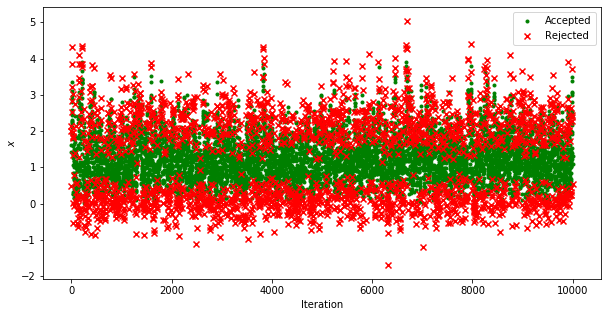

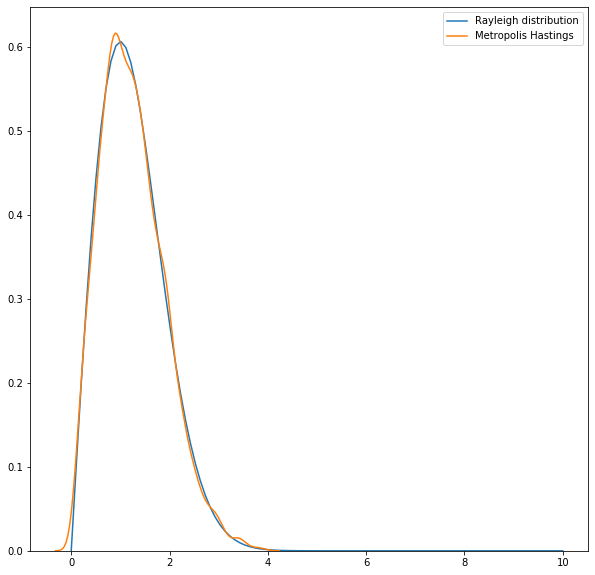

In [421]:
%%time
df = metropolisHastings(σ_q=0.5)

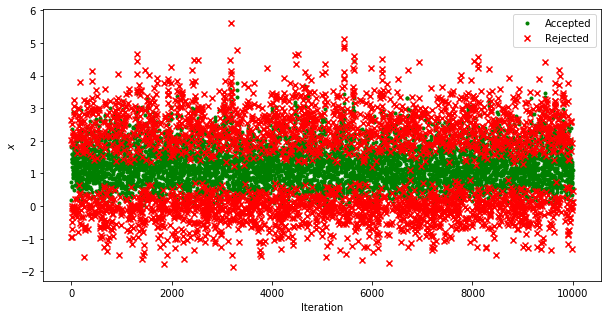

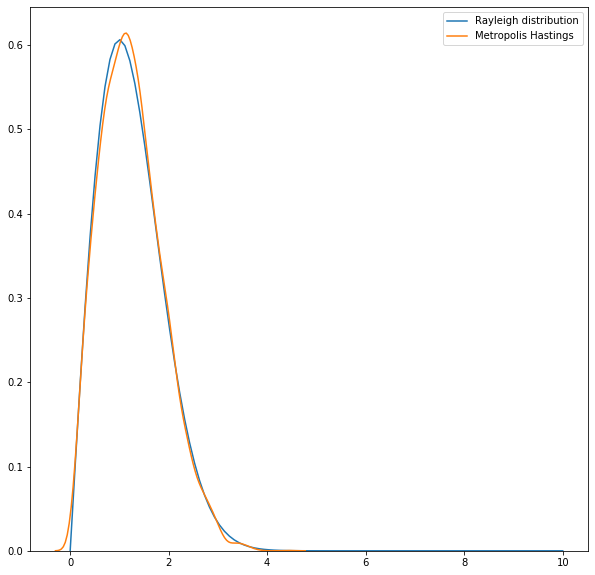

In [419]:
df = metropolisHastings(σ_q=0.75)

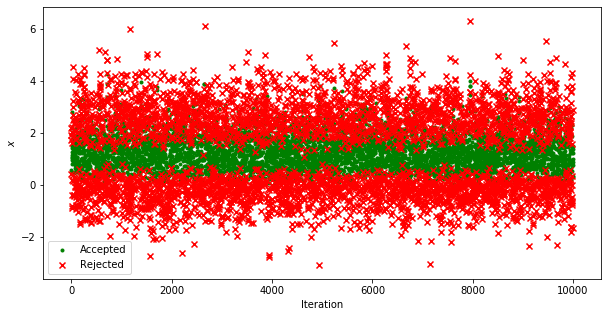

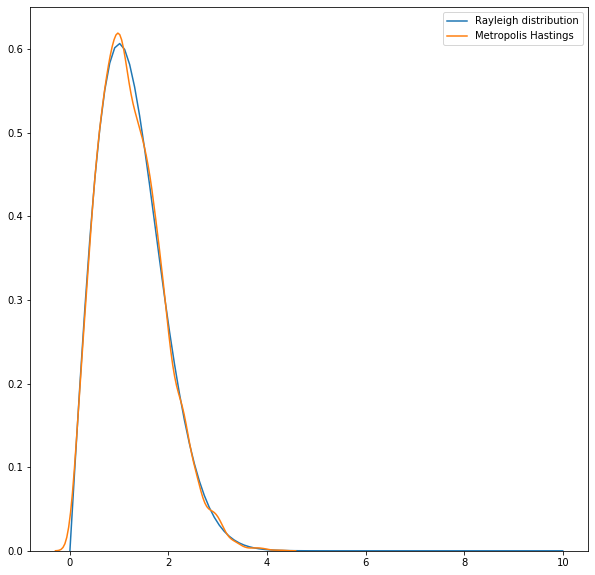

In [416]:
df = metropolisHastings(σ_q=1.0)

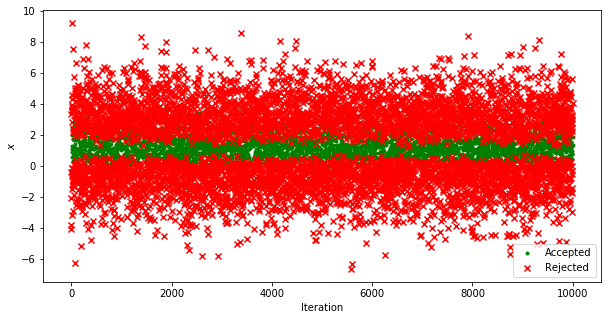

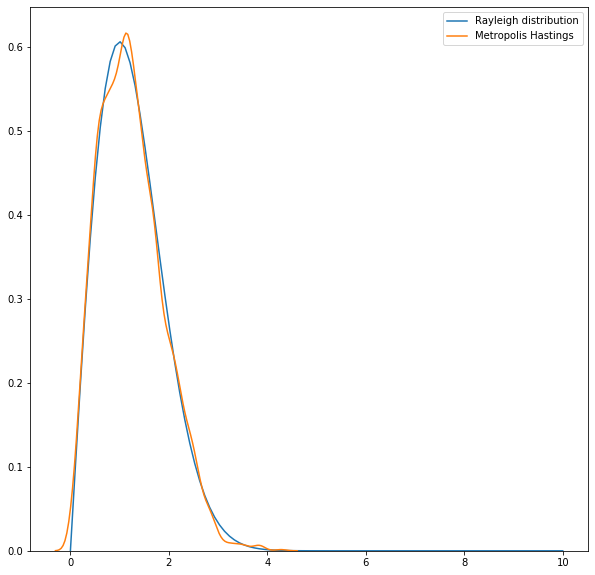

In [417]:
df = metropolisHastings(σ_q=2.0)

Wall time: 8.71 s


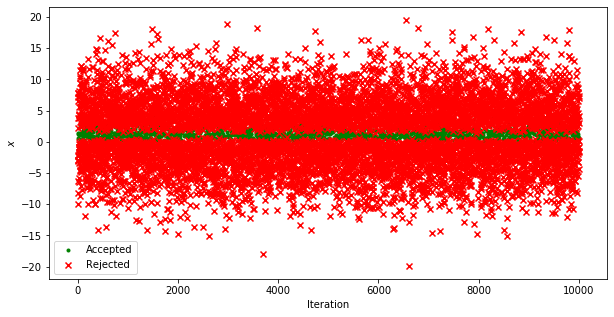

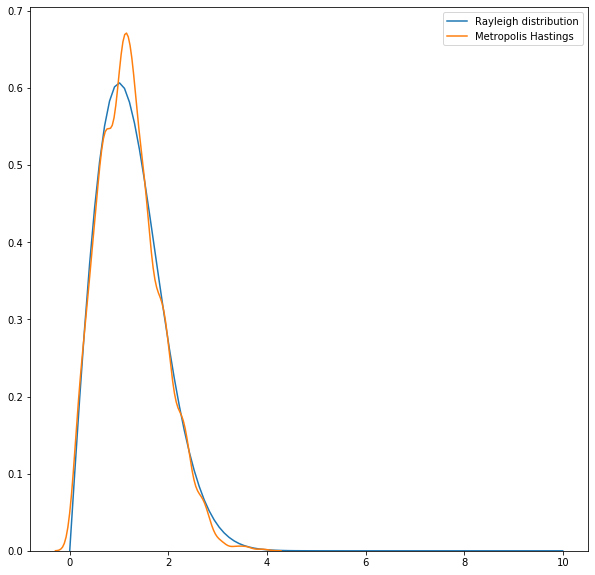

In [420]:
%%time
df = metropolisHastings(σ_q=5.0)

In [437]:
def metropolisHastings_a1(x=1.0,σ=1,σ_q=1,n=10000):
    iterations = []
    xs = []
    proposedXs = []
    arr_Accepted = []

    for t in range(0,10000):
        check = -1
        while check < 0:
            # obtain a proposed value from q
            proposedValue = q_x(x,σ_q)
            # calculate the acceptance probability
            acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
            check = f_rayleigh(proposedValue,σ)
            accepted = False
            # check if it falls within the support for fx (positive probability)
            if acceptanceRatio == 1: #accept
                x = proposedValue
                accepted = True
            else: # draw a random number and take the probability from acceptanceRatio
                rand = np.random.random()
                if rand < acceptanceRatio:
                    x = proposedValue
                    accepted = True
                else:
                    pass
        iterations.append(t)
        xs.append(x)
        proposedXs.append(proposedValue)
        arr_Accepted.append(accepted)
    df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})

    df_Accepted = df[df["accepted"]==True]
    df_Rejected = df[df["accepted"]==False]

    fig,ax = plt.subplots(figsize=(10,5))
    ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
    ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
    ax.legend()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("$x$")

    xs = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
    ax.legend()
    
    return df

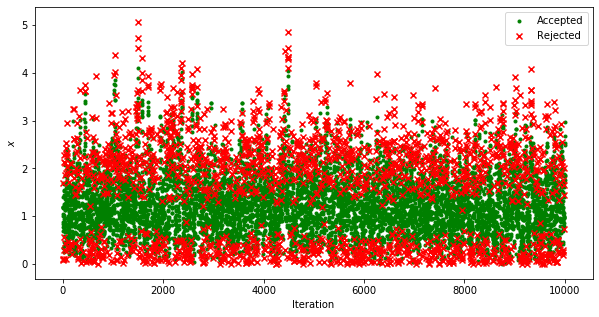

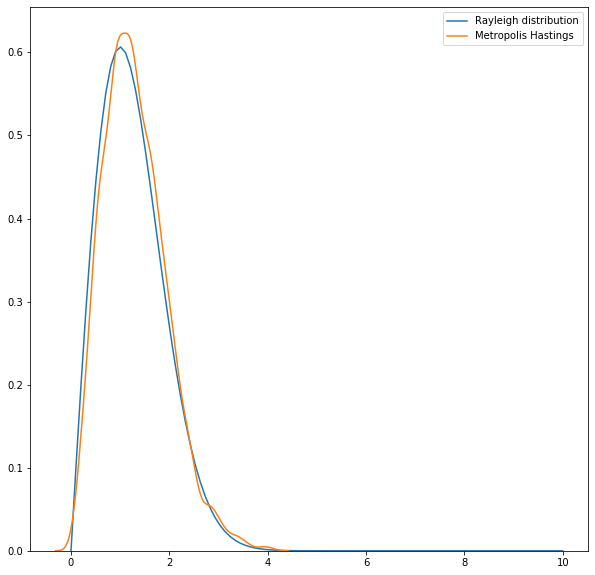

In [439]:
df = metropolisHastings_a1(σ_q=0.5)

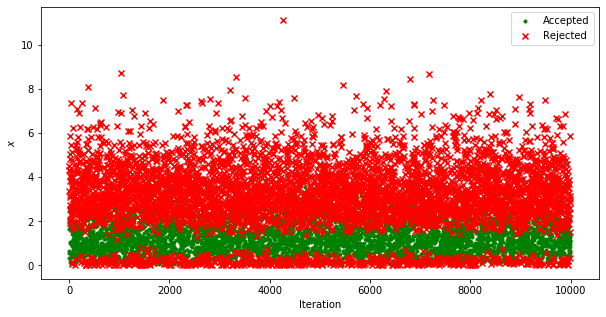

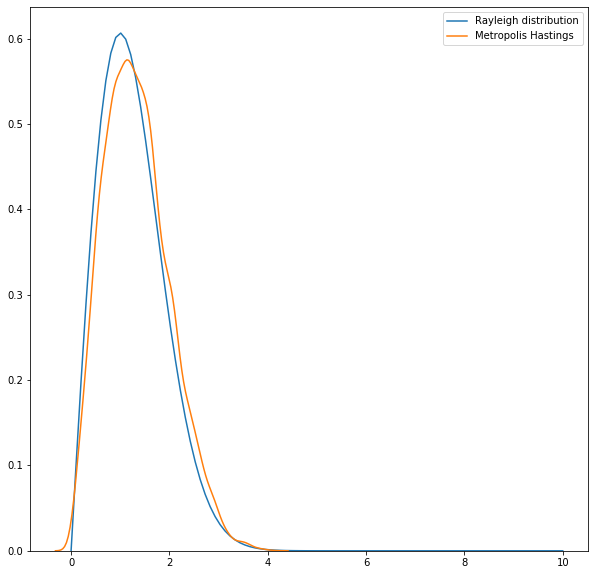

In [440]:
df = metropolisHastings_a1(σ_q=2.0)

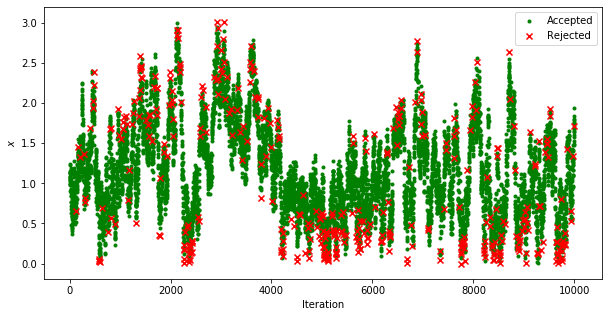

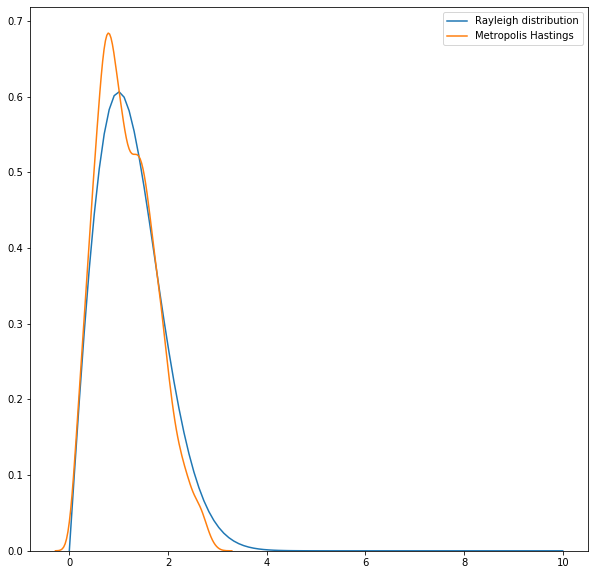

In [441]:
df = metropolisHastings_a1(σ_q=0.1)

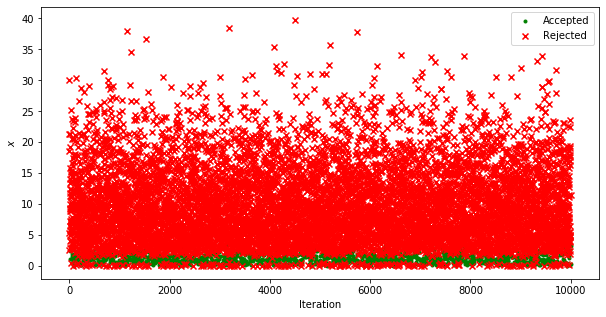

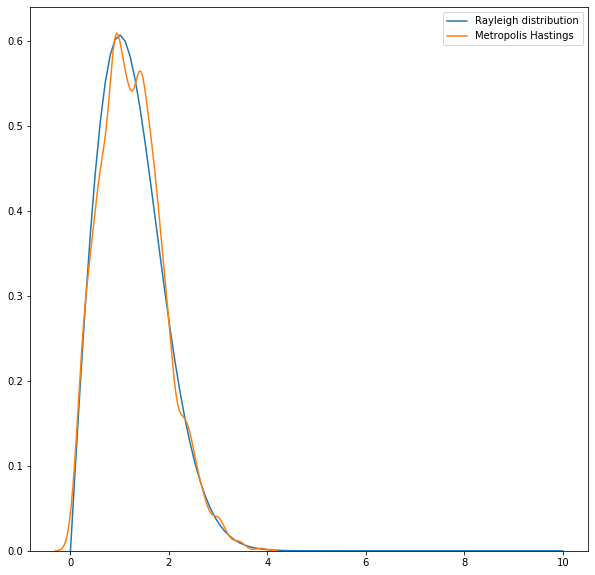

In [442]:
df = metropolisHastings_a1(σ_q=10)

### (c) Write an adaptive Metropolis algoirthm to sample from the target Rayleigh distribution with $\sigma = 1$.  Choose your own parameters

In [443]:
def adaptiveMetropolisHastings(x=1.0,σ=1,σ_q=1,n=10000,k=100):
    iterations = []
    xs = []
    proposedXs = []
    arr_Accepted = []

    for t in range(0,n):
        # obtain a proposed value from q
        proposedValue = q_x(x,σ_q)
        # calculate the acceptance probability
        acceptanceRatio = min(1,f_rayleigh(proposedValue,1) / f_rayleigh(x,1) * stats.norm.pdf(x,scale=σ_q,loc=proposedValue) / stats.norm.pdf(proposedValue,scale=σ_q,loc=x))
        accepted = False
        if acceptanceRatio == 1: #accept
            x = proposedValue
            accepted = True
        else: # draw a random number and take the probability from acceptanceRatio
            rand = np.random.random()
            if rand < acceptanceRatio:
                x = proposedValue
                accepted = True
            else:
                pass
        iterations.append(t)
        xs.append(x)
        proposedXs.append(proposedValue)
        arr_Accepted.append(accepted)
    df = pd.DataFrame({"t":iterations,"x":xs,"proposals":proposedXs,"accepted":arr_Accepted})
    
    df_Accepted = df[df["accepted"]==True]
    df_Rejected = df[df["accepted"]==False]

    fig,ax = plt.subplots(figsize=(10,5))
    ax.scatter(df_Accepted["t"],df_Accepted["x"],label="Accepted",marker=".",color="green")
    ax.scatter(df_Rejected["t"],df_Rejected["proposals"],label="Rejected",marker="x",color="red")
    ax.legend()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("$x$")
    
    xs = np.linspace(0,10,100)
    fs_rayleigh = [f_rayleigh(x,1) for x in xs]
    fig,ax = plt.subplots(figsize=(10,10))
    sns.lineplot(xs,fs_rayleigh,label="Rayleigh distribution",ax=ax)
    sns.kdeplot(df["x"],ax=ax,label="Metropolis Hastings")
    ax.legend()
    
    return df